## Project Introduction 
The airline industry thrives on customer satisfaction and trust, but with thousands of reviews scattered across platforms, it becomes challenging to distill actionable insights.

In this project, we analyze over 130,000 airline passenger reviews from the Skytrax database using Natural Language Processing (NLP). Our goal is to understand customer sentiment, identify service pain points, and uncover what truly drives positive experiences — from cabin comfort to food and crew service.

We apply text cleaning, sentiment scoring using VADER, feature correlation, and visual storytelling to provide strategic recommendations for airline operators, analysts, and customer experience teams.

Installs the wordcloud package, which is used later to generate visualizations of frequently mentioned words in positive and negative customer reviews.

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


Installs the nltk (Natural Language Toolkit) package, which includes the VADER sentiment analyzer used for scoring customer sentiment in text reviews.

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


Imports the Kaggle API and essential libraries including nltk, seaborn, matplotlib, and pandas to support dataset access, analysis, and visualization.

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Authenticates the Kaggle API and downloads the Skytrax airline review dataset directly into a local folder called skytrax_data, automatically unzipping it for access.

In [4]:
api = KaggleApi()
api.authenticate()

# Download and extract Skytrax dataset
api.dataset_download_files('efehandanisman/skytrax-airline-reviews', path='skytrax_data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/efehandanisman/skytrax-airline-reviews


Loads the extracted Excel file capstone_airline_reviews3.xlsx into a Pandas DataFrame and previews the first few rows using df.head(). The preview shows that some rows (e.g., row 0) are completely empty, which will be cleaned later.

In [5]:
# Load the Excel file
df = pd.read_excel('skytrax_data/capstone_airline_reviews3.xlsx')

# Preview the first few rows
df.head()

,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Displays the shape of the dataset using df.shape, confirming it contains 131,895 rows and 17 columns.

In [6]:
df.shape

(131895, 17)

Uses df.info() to inspect the structure of the dataset:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131895 entries, 0 to 131894
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          65947 non-null  object 
 1   overall          64017 non-null  float64
 2   author           65947 non-null  object 
 3   review_date      65947 non-null  object 
 4   customer_review  65947 non-null  object 
 5   aircraft         19718 non-null  object 
 6   traveller_type   39755 non-null  object 
 7   cabin            63303 non-null  object 
 8   route            39726 non-null  object 
 9   date_flown       39633 non-null  object 
 10  seat_comfort     60681 non-null  float64
 11  cabin_service    60715 non-null  float64
 12  food_bev         52608 non-null  float64
 13  entertainment    44193 non-null  float64
 14  ground_service   39358 non-null  float64
 15  value_for_money  63975 non-null  float64
 16  recommended      64440 non-null  object 
dtypes: float64

Calculates the total number of missing values per column using df.isnull().sum(). The result highlights:
- Over 65,000 missing values in key fields like airline and customer_review
- Substantial null counts in service ratings (e.g., food_bev, ground_service)

In [8]:
df.isnull().sum()

airline             65948
overall             67878
author              65948
review_date         65948
customer_review     65948
aircraft           112177
traveller_type      92140
cabin               68592
route               92169
date_flown          92262
seat_comfort        71214
cabin_service       71180
food_bev            79287
entertainment       87702
ground_service      92537
value_for_money     67920
recommended         67455
dtype: int64

Begins the data cleaning process by:
- Dropping rows with missing airline or customer_review
- Resetting the index of the cleaned DataFrame
- Fixing encoding issues in the text by decoding improperly encoded characters in customer reviews using latin1 to utf-8

In [9]:
# Drop rows where 'airline' or 'customer_review' is missing
df_clean = df.dropna(subset=['airline', 'customer_review']).copy()

# Optional: reset index
df_clean.reset_index(drop=True, inplace=True)

# Fix encoding issues in reviews
df_clean['customer_review'] = df_clean['customer_review'].apply(lambda x: str(x).encode('latin1', errors='ignore').decode('utf-8', errors='ignore'))

Computes a compound sentiment score for each review using VADER.
Classifies each review as positive, neutral, or negative based on score thresholds (≥ 0.05, ≤ –0.05)

In [10]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Compute sentiment score
df_clean['sentiment_score'] = df_clean['customer_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiment
df_clean['sentiment_label'] = df_clean['sentiment_score'].apply(
    lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral')
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\slind\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Creates a countplot to visualize the number of reviews by sentiment category (positive, negative, neutral).
The chart shows that the majority of reviews are positive, followed by negative, with neutral being a small minority.

C:\Users\slind\AppData\Local\Temp\ipykernel_20908\3159115427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='sentiment_label', palette='Set2')


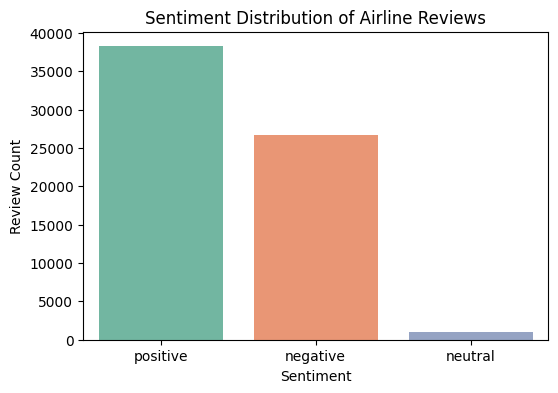

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution of Airline Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Review Count')
plt.show()

Plots a boxplot comparing overall star ratings (overall) across different sentiment labels.
The boxplot reveals a clear correlation between positive sentiment and higher ratings, while negative sentiment is concentrated at lower rating values.

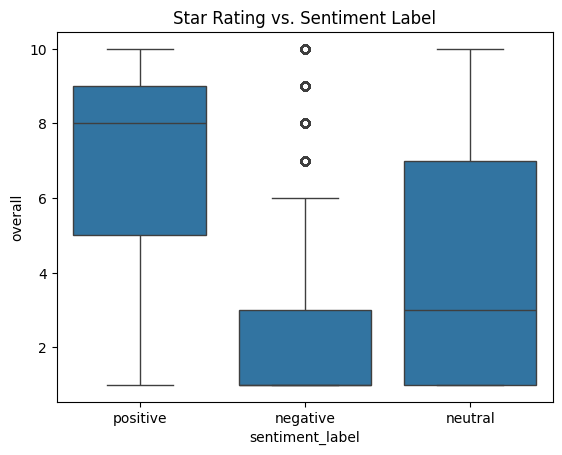

In [12]:
sns.boxplot(x='sentiment_label', y='overall', data=df_clean)
plt.title('Star Rating vs. Sentiment Label')
plt.show()

Word Clouds for Positive and Negative Reviews

The Word Cloud generated from positive reviews highlights frequent terms like "flight," "seat," "time," "food," "staff," and "airline." These words reflect customers' focus on comfort, service quality, and overall flight experience, often with a positive tone.

The visual uses a white background and provides insights into aspects valued by satisfied passengers.

The Word Cloud from negative reviews emphasizes issues like "flight," "airline," "delayed," "cancelled," and "service." These terms underscore recurring complaints about delays, customer service, and operational issues.

The background is black, highlighting frustrations and problems experienced by customers.

These visualizations help identify the most common themes in customer feedback, with the positive reviews focusing on service and comfort, while the negative reviews are more critical of operational issues.

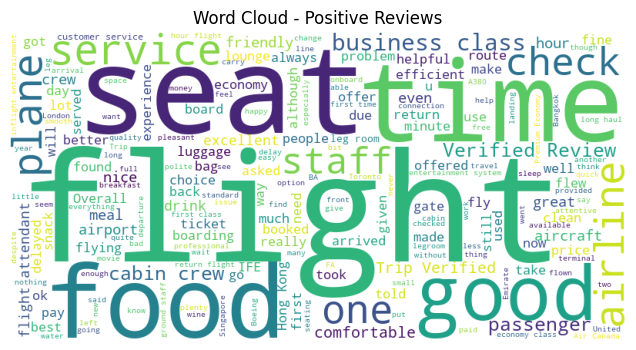

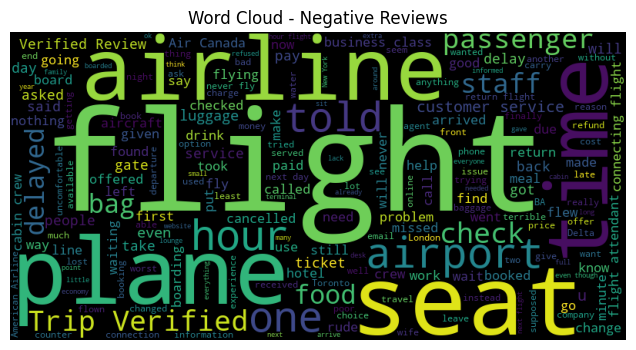

In [13]:
pos_reviews = " ".join(df_clean[df_clean['sentiment_label'] == 'positive']['customer_review'])
neg_reviews = " ".join(df_clean[df_clean['sentiment_label'] == 'negative']['customer_review'])

plt.figure(figsize=(10,4))
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(pos_reviews))
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(WordCloud(width=800, height=400, background_color='black').generate(neg_reviews))
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')
plt.show()

Next, we identifie the top 10 airlines by review count and visualizes the sentiment distribution (positive, negative, neutral) for each using a count plot. It highlights how customer perception varies by airline. This allows quick comparison of reputation across major carriers.

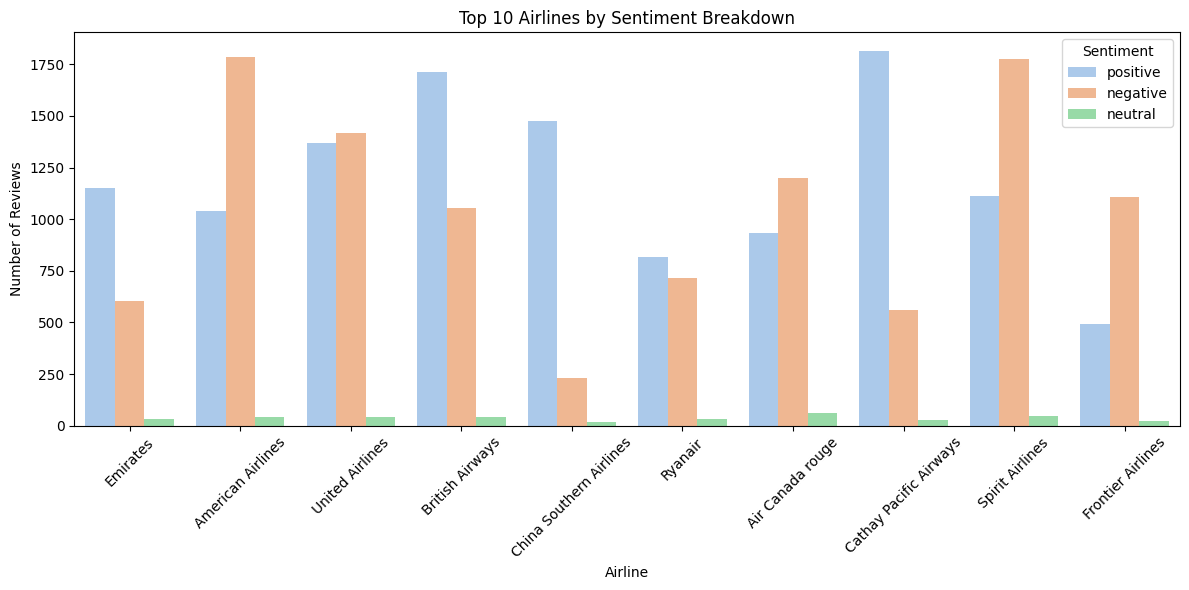

In [14]:
top_airlines = df_clean['airline'].value_counts().nlargest(10).index
df_top = df_clean[df_clean['airline'].isin(top_airlines)]

# Count plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top, x='airline', hue='sentiment_label', palette='pastel')
plt.title('Top 10 Airlines by Sentiment Breakdown')
plt.xticks(rotation=45)
plt.xlabel('Airline')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

Here, we visualize the sentiment distribution across different cabin classes using a count plot. It reveals that Economy Class receives the most reviews and also the highest volume of both positive and negative feedback. Higher-tier cabins like Business and First Class have fewer but predominantly positive reviews.


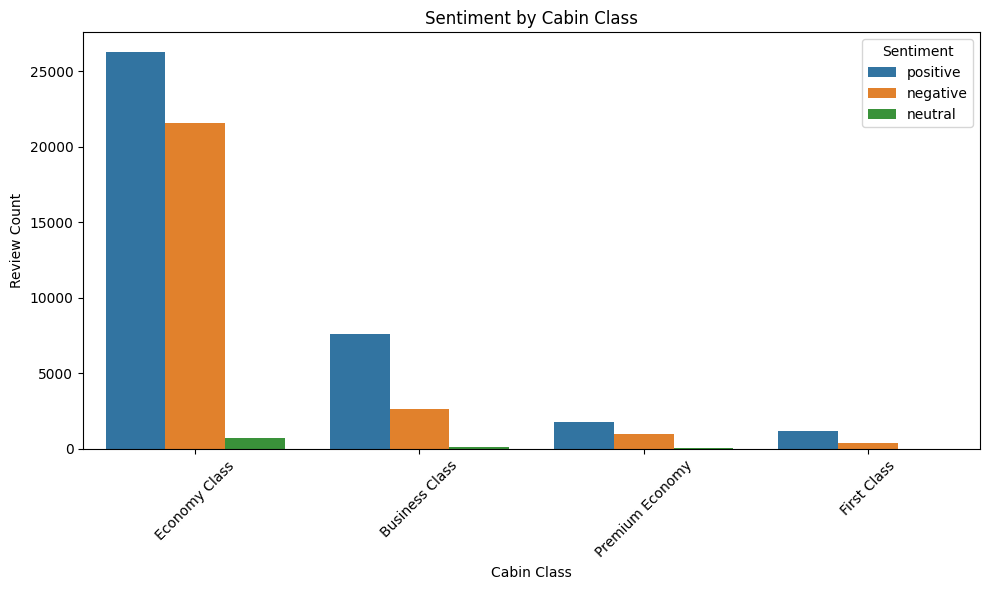

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='cabin', hue='sentiment_label', order=df_clean['cabin'].value_counts().index)
plt.title('Sentiment by Cabin Class')
plt.xticks(rotation=45)
plt.xlabel('Cabin Class')
plt.ylabel('Review Count')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

This heatmap illustrates how strongly individual service features correlate with the overall airline rating. "Value for money" (0.89), "ground service" (0.84), and "cabin service" (0.81) show the highest positive correlations, indicating that improvements in these areas are most likely to enhance a passenger’s overall experience.

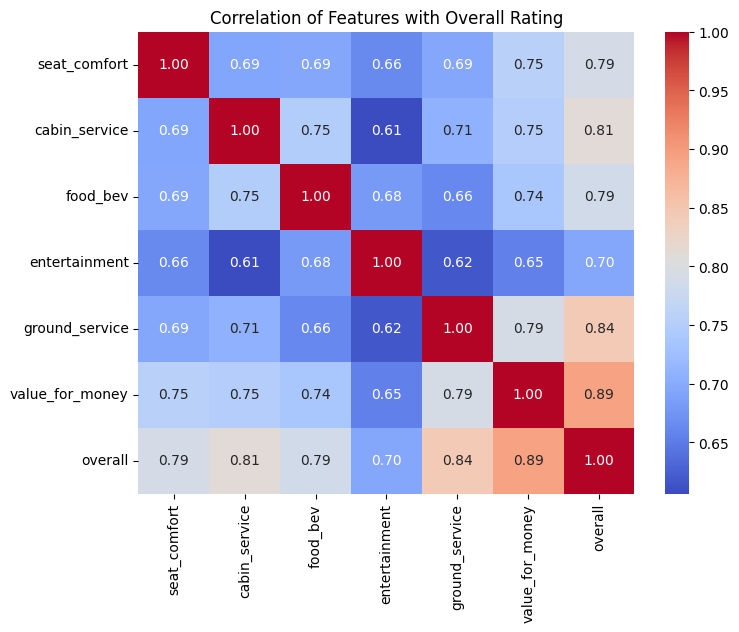

In [16]:
rating_features = ['seat_comfort', 'cabin_service', 'food_bev', 'entertainment', 'ground_service', 'value_for_money']
corr_matrix = df_clean[rating_features + ['overall']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with Overall Rating")
plt.show()

This visualization again shows the monthly trend of airline review sentiments. Positive sentiments dominated from 2013 to 2016 but began declining afterward, while negative sentiments gained traction post-2014 and approached parity by 2019. Neutral reviews stayed relatively flat and minimal across all years.

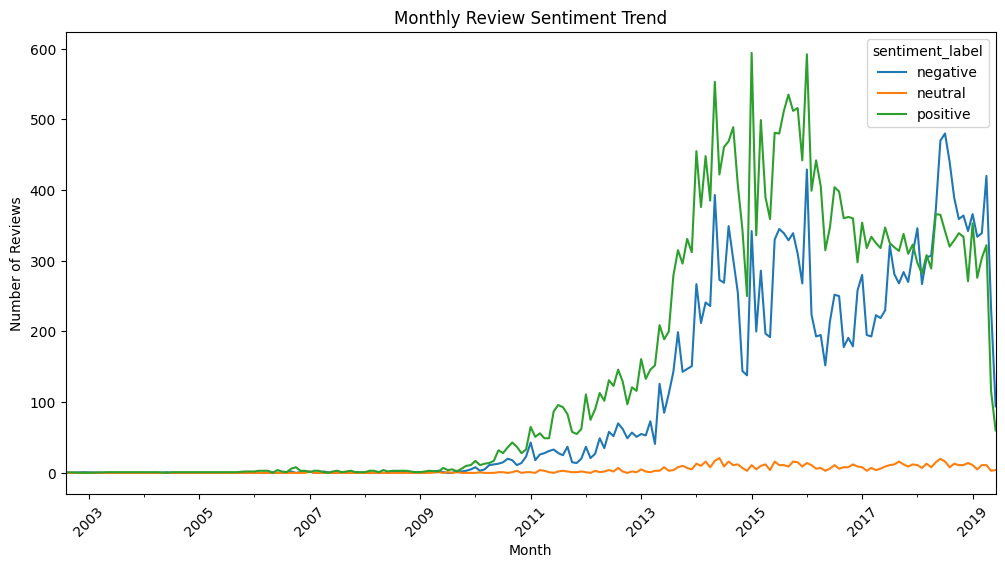

In [17]:
df_clean['review_date'] = pd.to_datetime(df_clean['review_date'], errors='coerce')

monthly_trend = df_clean.groupby(df_clean['review_date'].dt.to_period('M'))['sentiment_label'].value_counts().unstack().fillna(0)

monthly_trend.plot(kind='line', figsize=(12, 6))
plt.title('Monthly Review Sentiment Trend')
plt.ylabel('Number of Reviews')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

### Comprehensive Conclusion

This sentiment analysis of over 130,000 airline reviews offers several key insights for improving customer experience and operational focus:

1. **Data Cleaning and Structure**: The dataset contained substantial missing values, especially in columns like `aircraft`, `cabin`, and `route`. Cleaning involved removing rows lacking critical review content and handling encoding issues to ensure textual accuracy.

2. **Sentiment Distribution**: Using VADER sentiment scoring, the majority of customer reviews were classified as **positive**, followed by **negative**, with **neutral** being minimal. This polarity was visually supported by a bar plot and verified using sentiment labels derived from compound scores.

3. **Star Ratings and Sentiment**: There was a strong alignment between **higher star ratings** and **positive sentiment**, while **negative sentiment** was concentrated among lower-rated reviews, affirming the consistency of subjective ratings with textual sentiment.

4. **Word Clouds**:

   * **Positive reviews** frequently referenced “flight,” “service,” “staff,” and “food,” reflecting satisfaction with in-flight experience.
   * **Negative reviews** focused on terms like “delayed,” “told,” “problem,” and “cancelled,” underscoring operational failures and poor communication.

5. **Airline Comparison**: Among the top 10 airlines by review volume:

   * **Emirates**, **British Airways**, and **Cathay Pacific** saw predominantly positive sentiment.
   * **Spirit Airlines** and **American Airlines** showed a concerning skew toward negative sentiment, indicating reputation challenges.

6. **Cabin Class Insights**:

   * **Economy Class** dominated review counts and exhibited the widest sentiment variability, with a significant portion being negative.
   * **Business Class** passengers were more positive, suggesting a strong correlation between price tier and satisfaction.

7. **Feature Correlation**:

   * Factors like **value for money**, **ground service**, and **seat comfort** had the highest correlations with overall rating, indicating their importance in shaping customer satisfaction.

8. **Temporal Trends**:

   * From 2013 to 2016, **positive reviews surged**, aligning with industry investment in premium customer experience.
   * After 2016, **negative sentiment steadily increased**, peaking near 2019—likely due to increased delays, operational strain, or unmet expectations.

---

### Strategic Recommendations

* **Improve Ground Operations**: Given the high correlation of `ground_service` and `value_for_money` with overall satisfaction, investing in airport services and pricing transparency is key.
* **Target Economy Class Experience**: As the majority of dissatisfied reviews come from economy passengers, enhancing this segment could drive a notable improvement in sentiment.
* **Focus on Underperforming Airlines**: Carriers like Spirit and American Airlines should prioritize issue resolution, delay management, and front-line service improvements.
* **Monitor Trends Continuously**: Implement dashboards to track sentiment over time, allowing for agile responses to emerging customer pain points.

This analysis equips airline stakeholders with data-driven insights to prioritize service improvements, brand reputation strategies, and customer engagement initiatives.
